<img src="imgs/unicamp.png" width="150" height="150">

# Modelling

In [ ]:
# Default
import os

# Numerical and IO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP
import pickle
import nltk
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
folder = 'augmented/'
files_path = os.listdir(folder)
files = {}

# Get in order
for i in range(1, len(files_path)+1):
    
    file = [f for f in files_path if f'{i}' == f.split('_')[0]][0]
    files[file] = pd.read_csv(folder+file)
    files[file].columns = ['question', 'answer']
    files[file].dropna(inplace=True)

### Create corpus

In [3]:
corpus = []

for f in files:
    
    for indx, row in files[f].iterrows():
        
        corpus.append(row['question'])
        corpus.append(row['answer'])

### IO objects

In [4]:
def save(file: str, data):
    
    folder = 'pickles/'
    with open(f'{folder}{file}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(file: str):

    folder = 'pickles/'
    with open(f'{folder}{file}.pickle', 'rb') as handle:
        pick = pickle.load(handle)
    
    return pick

## Train Sentence Embedding

Source of sentence embedding Doc2Vec: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

In [5]:
# Tokenize
tokenized = [word_tokenize(c.lower()) for c in corpus]

# Tag
tagged = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized)]

# Train model
model = Doc2Vec(tagged, vector_size=50, window=2, min_count=1, epochs=100)

In [6]:
save('doc2vec', model)

In [7]:
# If restarted notebook
model = load('doc2vec')

## Prepare Data

Prepare data for hierarquical classifier.
- Which subject?
- Which question?

In [8]:
# Which subject?
class_sub = {}
X_sub, y_sub = [], []

for i, f in enumerate(files):

    class_sub[str(i+1)] = f
    X_sub.extend(files[f]['question'].values)
    y_sub.extend([str(i+1)]*len(files[f]['question'].values))

save('class_sub', class_sub)

In [9]:
# Which question?
class_que = {}
X_que, y_que = [], []
count = 0
last = ''

for i, f in enumerate(files):
    
    for j, row in files[f].iterrows():
        
        que = row['question']
        ans = row['answer']
        
        if last != ans:
            last = ans
            count += 1
        
        class_que[str(count)] = ans
        X_que.append(que)
        y_que.append(str(count))

save('class_que', class_que)

### Clean data

In [10]:
X_sub = [x.replace('\n', '') for x in X_sub]
X_que = [x.replace('\n', '') for x in X_que]

In [11]:
len(X_sub), len(y_sub), len(X_que), len(y_que)

(800, 800, 800, 800)

## Modelling

In [12]:
def split_data(X: list, y: list):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [13]:
def get_embedding(text: str):
    
    tokenized = word_tokenize(text.lower())
    return model.infer_vector(tokenized)

In [14]:
def make_it_vector(X: list):
    
    vectors = []
    
    for text in X:
        vectors.append(get_embedding(text))
        
    return vectors

In [15]:
def evaluate(model, X, y):
    
    return cross_val_score(model, X, y, cv=5, scoring='f1_macro')

In [16]:
def get_network(classes_len):
    
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_dim=50),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(classes_len, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [17]:
def one_hot_label(ys):
    
    y_ohe = []
    ys = list(map(int, ys))
    maxi = np.amax(ys)
    
    for y in ys:
        y_ohe.append([1 if i == y else 0 for i in range(maxi)])
    
    return np.array(y_ohe)

In [18]:
def random_forest_classifier(X_train_vec, y_train, X_test_vec, y_test):
    # Create Model
    model = RandomForestClassifier(random_state=42)

    # Evaluate
    cv_score = evaluate(model, X_train_vec, y_train).mean()

    # Fit and test
    model.fit(X_train_vec, y_train)
    pred = model.predict(X_test_vec)
    test_score = f1_score(y_test, pred, average='macro')

    return model, cv_score, test_score

In [19]:
def mlp_classifier(X_train_vec, y_train, X_test_vec, y_test):
    # Create Model
    model = MLPClassifier(max_iter=300, random_state=42)

    # Evaluate
    cv_score = evaluate(model, X_train_vec, y_train).mean()

    # Fit and test
    model.fit(X_train_vec, y_train)
    pred = model.predict(X_test_vec)
    test_score = f1_score(y_test, pred, average='macro')

    return model, cv_score, test_score

In [20]:
def gradient_boosting_classifier(X_train_vec, y_train, X_test_vec, y_test):
    # Create Model
    model = GradientBoostingClassifier(random_state=42)

    # Evaluate
    cv_score = evaluate(model, X_train_vec, y_train).mean()

    # Fit and test
    model.fit(X_train_vec, y_train)
    pred = model.predict(X_test_vec)
    test_score = f1_score(y_test, pred, average='macro')

    return model, cv_score, test_score


In [21]:
def logistic_regression(X_train_vec, y_train, X_test_vec, y_test):
    # Create Model
    model = LogisticRegression(random_state=42)

    # Evaluate
    cv_score = evaluate(model, X_train_vec, y_train).mean()

    # Fit and test
    model.fit(X_train_vec, y_train)
    pred = model.predict(X_test_vec)
    test_score = f1_score(y_test, pred, average='macro')

    return model, cv_score, test_score

In [22]:
def get_data_per_subject(subject):
    start = (subject-1)*50
    end = start + 50

    X_que_filt = np.array(X_que)[start:end]
    y_que_filt = np.array(y_que)[start:end]

    return X_que_filt, y_que_filt

In [23]:
def split_data_per_subject(subject):
    # Get data
    X_que_filt, y_que_filt = get_data_per_subject(subject)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X_que_filt, y_que_filt)

    # Make X vector
    X_train_vec = make_it_vector(X_train)
    X_test_vec = make_it_vector(X_test)

    return X_train_vec, X_test_vec, y_train, y_test

### Subject

In [63]:
# Split data
X_train, X_test, y_train, y_test = split_data(X_sub, y_sub)

# Make X vector
X_train_vec = make_it_vector(X_train)
X_test_vec = make_it_vector(X_test)

In [64]:
# Random forest classifier
rf_model, rf_train_score, rf_test_score = random_forest_classifier(X_train_vec, y_train, X_test_vec, y_test)

In [26]:
# Save the model
save('sub_model', rf_model)

In [65]:
# MLP classifier
mlp_model, mlp_train_score, mlp_test_score = mlp_classifier(X_train_vec, y_train, X_test_vec, y_test)

In [66]:
# Gradient boosting classifier
gb_model, gb_train_score, gb_test_score = gradient_boosting_classifier(X_train_vec, y_train, X_test_vec, y_test)

In [67]:
# Logistic regression
lr_model, lr_train_score, lr_test_score = logistic_regression(X_train_vec, y_train, X_test_vec, y_test)

In [30]:
# model = get_network(16)

# X_train_nn = np.array(X_train_vec)
# X_test_nn = np.array(X_test_vec)
# y_train_ohe = one_hot_label(y_train)
# y_test_ohe = one_hot_label(y_test)

# history = model.fit(X_train_nn, y_train_ohe, epochs=100, validation_data=(X_test_nn, y_test_ohe))

### Question

In [31]:
subject = 16

start = (subject-1)*50
end = start + 50

X_que_filt = np.array(X_que)[start:end]
y_que_filt = np.array(y_que)[start:end]

In [32]:
# Split data
X_train_que, X_test_que, y_train_que, y_test_que = split_data(X_que_filt, y_que_filt)

# Make X vector
X_train_vec_que = make_it_vector(X_train_que)
X_test_vec_que = make_it_vector(X_test_que)

In [33]:
# Random forest classifier
rf_que_model, rf_que_train_score, rf_que_test_score = random_forest_classifier(X_train_vec_que, y_train_que, X_test_vec_que, y_test_que)

In [34]:
# Save the model
save(f'{subject}_que_model', rf_model)

In [35]:
# MLP classifier
mlp_que_model, mlp_que_train_score, mlp_que_test_score = mlp_classifier(X_train_vec_que, y_train_que, X_test_vec_que, y_test_que)

In [36]:
# Gradient boosting classifier
gb_que_model, gb_que_train_score, gb_que_test_score = gradient_boosting_classifier(X_train_vec_que, y_train_que, X_test_vec_que, y_test_que)

In [37]:
# Logistic regression
lr_que_model, lr_que_train_score, lr_que_test_score = logistic_regression(X_train_vec_que, y_train_que, X_test_vec_que, y_test_que)

## Compare and Select

In [38]:
def plot_metrics(train_scores, test_scores, title=None):
    x = np.arange(4)
    width = 0.3

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    ax.bar(x, train_scores, width, label='Cross validation score')
    ax.bar(x + width, test_scores, width, label='F1 score')
    ax.set_title(title)
    ax.set_axisbelow(True)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 0.6))
    plt.xticks(x + width / 2, ('Random Forest','MLP','Gradient Boosting','Logistic Regression'))
    plt.show()

In [39]:
def save_selection_models(models, names):
    for model, name in zip(models, names):
        save('selection_tunning/' + name, rf_model)

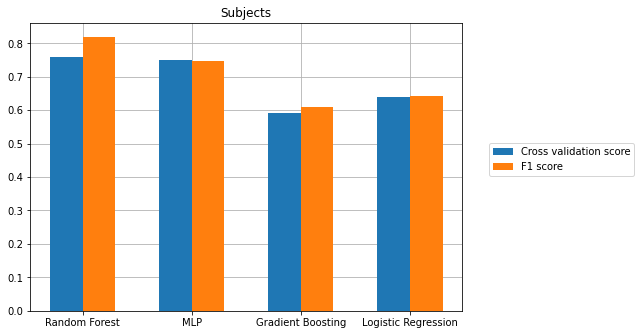

In [70]:
# Subject
# Saving models
models = [rf_model, mlp_model, gb_model, lr_model]
names = ['sub_rf_model', 'sub_mlp_model', 'sub_gb_model', 'sub_lr_model']
save_selection_models(models, names)

# Plots
train_scores = [rf_train_score, mlp_train_score, gb_train_score, lr_train_score]
test_scores = [rf_test_score, mlp_test_score, gb_test_score, lr_test_score]
plot_metrics(train_scores, test_scores, 'Subjects')

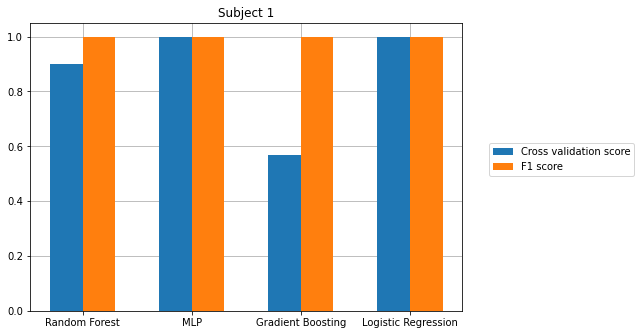

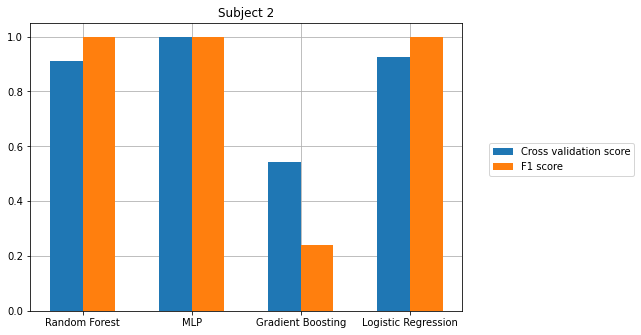

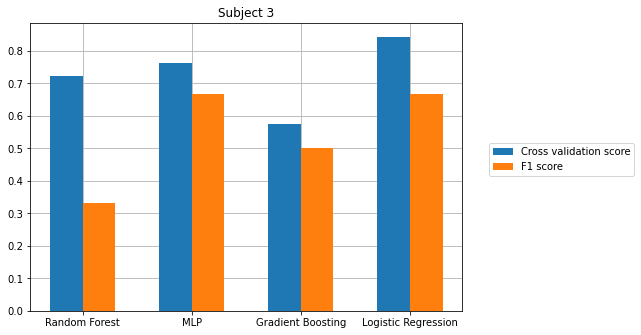

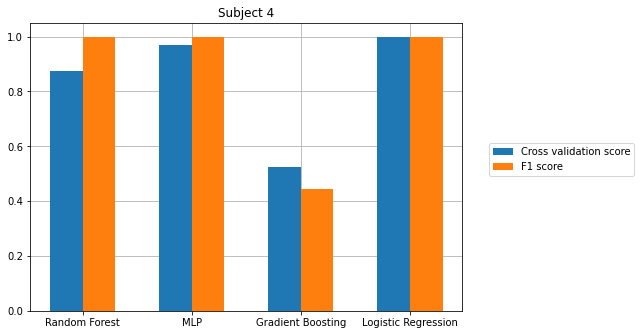

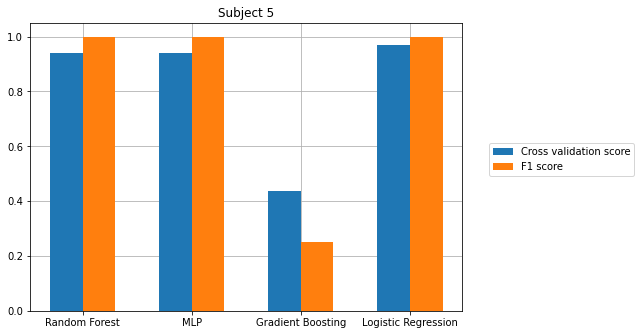

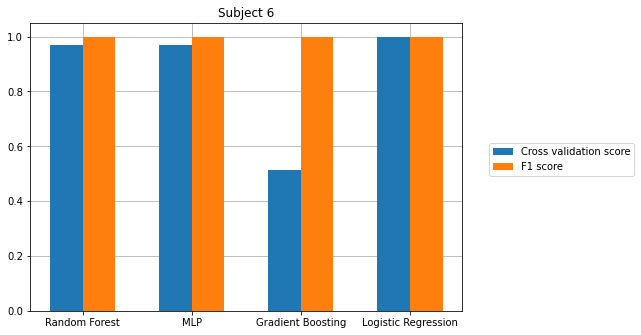

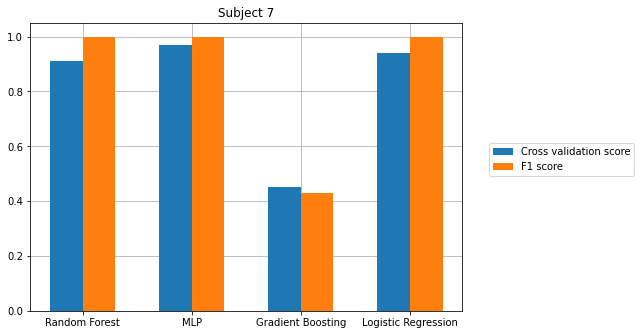

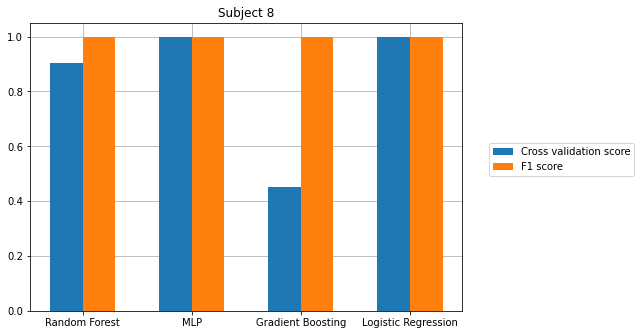

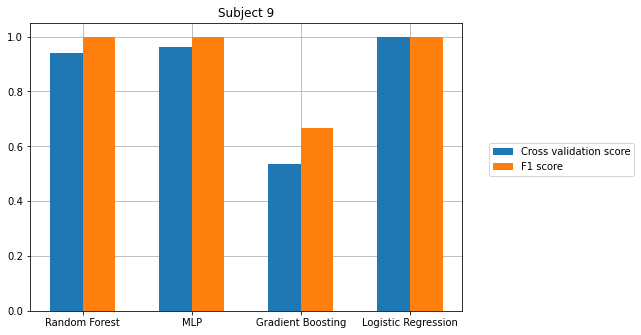

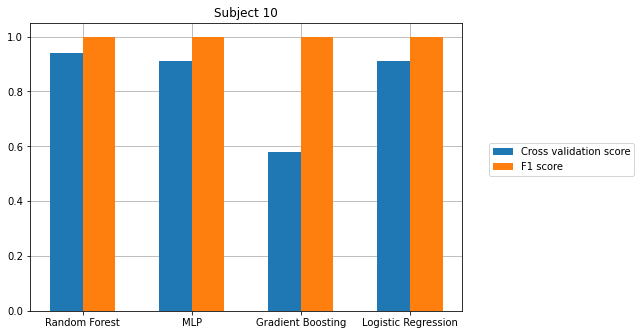

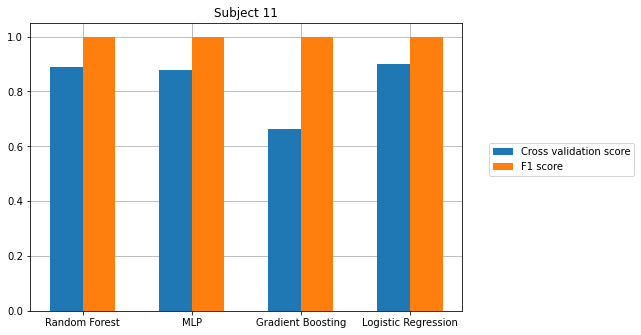

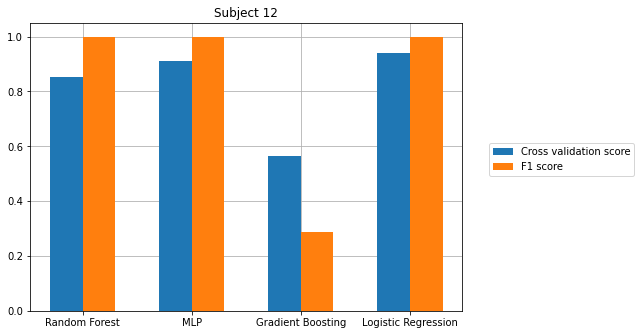

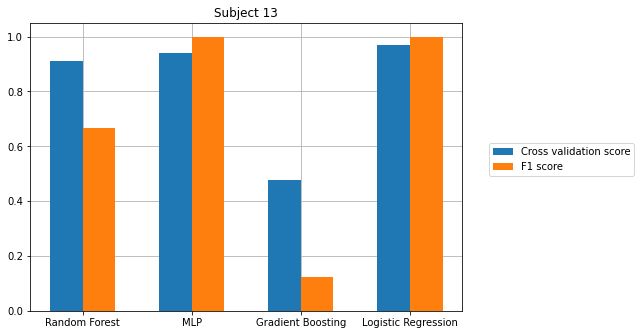

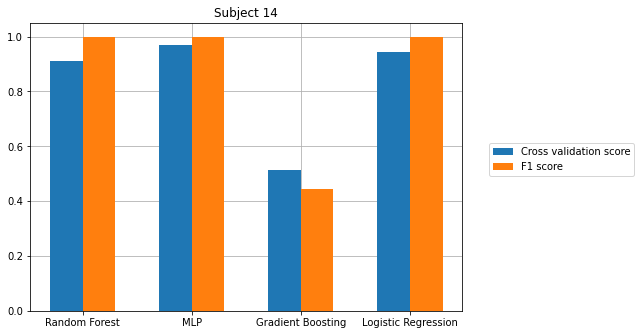

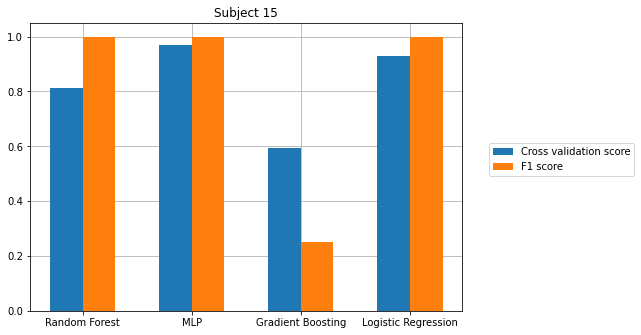

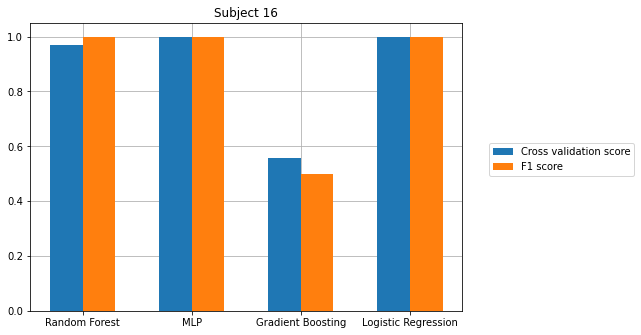

In [41]:
# Questions
for subject in range(1, 17):
    X_train_vec, X_test_vec, y_train, y_test = split_data_per_subject(subject)

    rf_model, rf_train_score, rf_test_score = random_forest_classifier(X_train_vec, y_train, X_test_vec, y_test)
    mlp_model, mlp_train_score, mlp_test_score = mlp_classifier(X_train_vec, y_train, X_test_vec, y_test)
    gb_model, gb_train_score, gb_test_score = gradient_boosting_classifier(X_train_vec, y_train, X_test_vec, y_test)
    lr_model, lr_train_score, lr_test_score = logistic_regression(X_train_vec, y_train, X_test_vec, y_test)

    # Saving models
    models = [rf_model, mlp_model, gb_model, lr_model]
    names = [f'{subject}_rf_que_model', f'{subject}_mlp_que_model', f'{subject}_gb_que_model', f'{subject}_lr_que_model']
    save_selection_models(models, names)

    # Plots
    train_scores = [rf_train_score, mlp_train_score, gb_train_score, lr_train_score]
    test_scores = [rf_test_score, mlp_test_score, gb_test_score, lr_test_score]
    plot_metrics(train_scores, test_scores, 'Subject {}'.format(subject))